# Tarea 4 Realce de Imagenes

#### Kevin Andrés Pulido Rodríguez, kapulidor@unal.edu.co
#### Carlos Alejandro Salazar Sánchez, caasalazarsa@unal.edu.co

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import math

###### 1) Implementación de filtros

In [2]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size=3):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance**2 / (img_variance**2 + overall_variance**2)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Copyright 2012 - 2013
# Matías Herranz <matiasherranz@gmail.com>
# Joaquín Tita <joaquintita@gmail.com>
#
# https://github.com/PyRadar/pyradar
#
# This library is free software; you can redistribute it and/or
# modify it under the terms of the GNU Lesser General Public
# License as published by the Free Software Foundation; either
# version 3 of the License, or (at your option) any later version.
#
# This library is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
# Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public
# License along with this library. If not, see <http://www.gnu.org/licenses/>.

from scipy.stats import variation

from utils import assert_window_size
from utils import assert_indices_in_range

COEF_VAR_DEFAULT = 0.01
CU_DEFAULT = 0.25


def weighting(window, cu=CU_DEFAULT):
    """
    Computes the weighthing function for Kuan filter using cu as the noise
    coefficient.
    """
    two_cu = cu * cu

    ci = variation(window, None)
    two_ci = ci * ci

    if not two_ci:  # dirty patch to avoid zero division
        two_ci = COEF_VAR_DEFAULT

    divisor = 1.0 + two_cu

    if not divisor:
        divisor = 0.0001

    if cu > ci:
        w_t = 0.0
    else:
        w_t = (1.0 - (two_cu / two_ci)) / divisor

    return w_t


def kuan_filter(img, win_size=3, cu=CU_DEFAULT):
    
    
    """
    Apply kuan to a numpy matrix containing the image, with a window of
    win_size x win_size.
    """
    assert_window_size(win_size)

    # we process the entire img as float64 to avoid type overflow error
    img = np.float64(img)
    img_filtered = np.zeros_like(img)

    N, M = img.shape
    win_offset = win_size / 2

    for i in range(N):
        xleft = i - win_offset
        xright = i + win_offset

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in range(M):
            yup = j - win_offset
            ydown = j + win_offset

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            pix_value = img[i, j]
            window = img[int(xleft):int(xright), int(yup):int(ydown)]
            w_t = weighting(window, cu)
            window_mean = window.mean()
            new_pix_value = (pix_value * w_t) + (window_mean * (1.0 - w_t))

            img_filtered[i, j] = round(new_pix_value)

    return img_filtered

In [32]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Copyright 2012 - 2013
# Matías Herranz <matiasherranz@gmail.com>
# Joaquín Tita <joaquintita@gmail.com>
#
# https://github.com/PyRadar/pyradar
#
# This library is free software; you can redistribute it and/or
# modify it under the terms of the GNU Lesser General Public
# License as published by the Free Software Foundation; either
# version 3 of the License, or (at your option) any later version.
#
# This library is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
# Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public
# License along with this library. If not, see <http://www.gnu.org/licenses/>.


from utils import assert_window_size
from utils import assert_indices_in_range

COEF_VAR_DEFAULT = 0.01


def compute_coef_var(image, x_start, x_end, y_start, y_end):
    """
    Compute coefficient of variation in a window of [x_start: x_end] and
    [y_start:y_end] within the image.
    """
    assert x_start >= 0, 'ERROR: x_start must be >= 0.'
    assert y_start >= 0, 'ERROR: y_start must be >= 0.'

    x_size, y_size = image.shape
    x_overflow = x_end > x_size
    y_overflow = y_end > y_size

    assert not x_overflow, 'ERROR: invalid parameters cause x window overflow.'
    assert not y_overflow, 'ERROR: invalid parameters cause y window overflow.'

    window = image[int(x_start):int(x_end), int(y_start):int(y_end)]

    coef_var = variation(window, None)

    if not coef_var:  # dirty patch
        coef_var = COEF_VAR_DEFAULT
#        print "squared_coef was equal zero but replaced by %s" % coef_var
    if coef_var>=0:
        coef_var=0.001
    #assert coef_var > 0, 'ERROR: coeffient of variation cannot be zero.'

    return coef_var


def calculate_all_Mi(window_flat, factor_A, window):
    """
    Compute all the weights of pixels in the window.
    """
    N, M = window.shape
    center_pixel = np.float64(window[int(N / 2), int(M / 2)])
    window_flat = np.float64(window_flat)

    distances = np.abs(window_flat - center_pixel)

    weights = np.exp(-factor_A * distances)

    return weights


def calculate_local_weight_matrix(window, factor_A):
    """
    Returns an array with the weights for the pixels in the given window.
    """
    weights_array = np.zeros(window.size)
    window_flat = window.flatten()

    weights_array = calculate_all_Mi(window_flat, factor_A, window)

    return weights_array


def frost_filter(img, damping_factor=2.0, win_size=3):
    """
    Apply frost filter to a numpy matrix containing the image, with a window of
    win_size x win_size.
    By default, the window size is 3x3.
    """

    assert_window_size(win_size)

    img_filtered = np.zeros_like(img)
    N, M = img.shape
    win_offset = win_size / 2

    for i in range(N):
        xleft = i - win_offset
        xright = i + win_offset
        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N - 1
        for j in range(M):
            yup = j - win_offset
            ydown = j + win_offset
            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M - 1

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            # inspired by http://www.pcigeomatics.com/cgi-bin/pcihlp/FFROST
            variation_coef = compute_coef_var(img, xleft, xright, yup, ydown)
            window = img[int(xleft):int(xright), int(yup):int(ydown)]
            window_mean = window.mean()
            sigma_zero = variation_coef / window_mean  # var / u^2
            factor_A = damping_factor * sigma_zero

            weights_array = calculate_local_weight_matrix(window, factor_A)
            pixels_array = window.flatten()

            weighted_values = weights_array * pixels_array
            if math.isnan(weighted_values.sum()) or math.isnan(weights_array.sum()) or weights_array.sum()==0:
                img_filtered[i, j] = img_filtered[i, j-1]
            else:
                img_filtered[i, j] = weighted_values.sum() / weights_array.sum()

    return img_filtered

##### 2) Estimación de nivel de ruido

In [33]:
def SNR(img):
    ybar=np.mean(img)
    sigma=np.std(img)
    SNR=ybar/sigma
    return SNR

In [34]:
def ENL(img):
    ybar=np.mean(img)
    sigma=np.std(img)
    ENL=(ybar/sigma)**2
    return ENL

In [35]:
def SSI(img,imgf):
    ybar=np.mean(img)
    sigma=np.std(img)
    ybarf=np.mean(imgf)
    sigmaf=np.std(imgf)
    SSI=(sigmaf/ybarf)*(ybar/sigma)
    return SSI

In [36]:
def SMPI(img,imgf):
    ybar=np.mean(img)
    sigma=np.std(img)
    ybarf=np.mean(imgf)
    sigmaf=np.std(imgf)
    M0=1+np.abs(ybar-ybarf)
    SMPI=M0*(sigmaf/sigma)
    return SMPI

In [37]:
def Q_factor(img,imgf):
    ybar=np.mean(img)
    sigma=np.std(img)
    ybarf=np.mean(imgf)
    sigmaf=np.std(imgf)
    L0=(ybar/sigma)**2
    ybars=ybar-np.abs(ybar-ybarf)
    Q=ybars**2/(L0*sigmaf)
    return Q

##### 3) Evaluación de desempeño de filtros

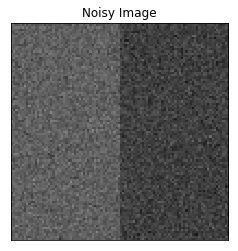

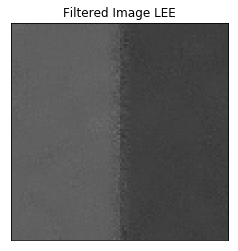

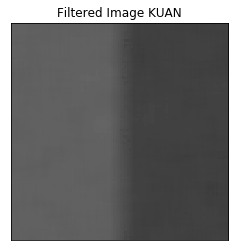

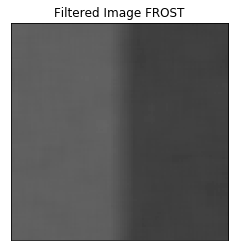

In [38]:
img = np.random.normal(0.5, 0.1, (100,100))
img[:,:50] += 0.25
img=img*128
img_lee=lee_filter(img,size=11)
img_kuan=kuan_filter(img,win_size=11)
img_frost=frost_filter(img,win_size=11)
plt.imshow(img, vmin=0, vmax=256, cmap='gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_lee, vmin=0, vmax=256, cmap='gray')
plt.title('Filtered Image LEE'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_kuan, vmin=0, vmax=256, cmap='gray')
plt.title('Filtered Image KUAN'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_frost, vmin=0, vmax=256, cmap='gray')
plt.title('Filtered Image FROST'), plt.xticks([]), plt.yticks([])
plt.show()

In [39]:
print('SNR_in: ',SNR(img), ' SNR_LEE: ',SNR(img_lee), ' SNR_KUAN: ',SNR(img_kuan), ' SNR_FROST: ',SNR(img_frost))
print('ENL_in: ',ENL(img), ' ENL_LEE: ',ENL(img_lee), ' ENL_KUAN: ',ENL(img_kuan), ' ENL_FROST: ',ENL(img_frost))
print('SSI_in: ',SSI(img,img), ' SSI_LEE: ',SSI(img,img_lee), ' SSI_KUAN: ',SSI(img,img_kuan), ' SSI_FROST: ',SSI(img,img_frost))
print('SMPI_in: ',SMPI(img,img), ' SMPI_LEE: ',SMPI(img,img_lee), ' SMPI_KUAN: ',SMPI(img,img_kuan), ' SMPI_FROST: ',SMPI(img,img_frost))
print('Q_in: ',Q_factor(img,img), ' Q_LEE: ',Q_factor(img,img_lee), ' Q_KUAN: ',Q_factor(img,img_kuan), ' Q_FROST: ',Q_factor(img,img_frost))

SNR_in:  3.910920743743972  SNR_LEE:  5.065052862220236  SNR_KUAN:  5.1819126776581985  SNR_FROST:  5.185570461459089
ENL_in:  15.295301063846905  ENL_LEE:  25.65476049708541  ENL_KUAN:  26.85221899887476  ENL_FROST:  26.890141010757027
SSI_in:  1.0  SSI_LEE:  0.7721381889052276  SSI_KUAN:  0.7547253276972219  SSI_FROST:  0.7541929615673446
SMPI_in:  1.0  SMPI_LEE:  0.7731388597095851  SMPI_KUAN:  0.9800788630782268  SMPI_FROST:  0.9941337583744541
Q_in:  20.496849197800145  Q_LEE:  26.54513651528554  Q_KUAN:  26.860820641732698  Q_FROST:  26.860481019262572


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1196: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


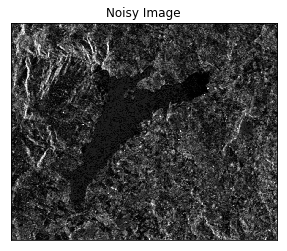

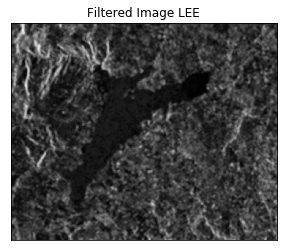

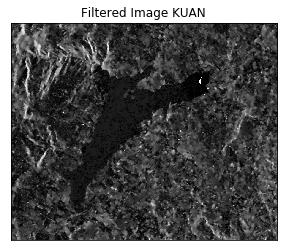

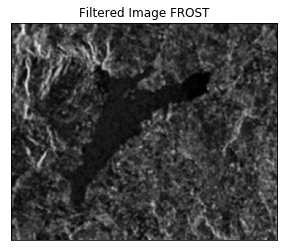

In [40]:
img=cv2.imread('lacopa_1.jpeg',0)

img_lee=lee_filter(img,size=11)
img_kuan=kuan_filter(img,win_size=11)
img_frost=frost_filter(img,win_size=11)
plt.imshow(img, cmap='gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_lee, cmap='gray')
plt.title('Filtered Image LEE'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_kuan, cmap='gray')
plt.title('Filtered Image KUAN'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_frost, cmap='gray')
plt.title('Filtered Image FROST'), plt.xticks([]), plt.yticks([])
plt.show()

In [41]:
print('SNR_in: ',SNR(img), ' SNR_LEE: ',SNR(img_lee), ' SNR_KUAN: ',SNR(img_kuan), ' SNR_FROST: ',SNR(img_frost))
print('ENL_in: ',ENL(img), ' ENL_LEE: ',ENL(img_lee), ' ENL_KUAN: ',ENL(img_kuan), ' ENL_FROST: ',ENL(img_frost))
print('SSI_in: ',SSI(img,img), ' SSI_LEE: ',SSI(img,img_lee), ' SSI_KUAN: ',SSI(img,img_kuan), ' SSI_FROST: ',SSI(img,img_frost))
print('SMPI_in: ',SMPI(img,img), ' SMPI_LEE: ',SMPI(img,img_lee), ' SMPI_KUAN: ',SMPI(img,img_kuan), ' SMPI_FROST: ',SMPI(img,img_frost))
print('Q_in: ',Q_factor(img,img), ' Q_LEE: ',Q_factor(img,img_lee), ' Q_KUAN: ',Q_factor(img,img_kuan), ' Q_FROST: ',Q_factor(img,img_frost))

SNR_in:  1.3946062437536966  SNR_LEE:  1.852532669231635  SNR_KUAN:  nan  SNR_FROST:  1.870854217343647
ENL_in:  1.944926575116795  ENL_LEE:  3.4318772905704864  ENL_KUAN:  nan  ENL_FROST:  3.5000955025525102
SSI_in:  1.0  SSI_LEE:  0.7528106072926259  SSI_KUAN:  nan  SSI_FROST:  0.7454382232592359
SMPI_in:  1.0  SMPI_LEE:  1.4638171398701783  SMPI_KUAN:  nan  SMPI_FROST:  1.1331911142340012
Q_in:  36.165880899882616  Q_LEE:  47.104720377554685  Q_KUAN:  nan  Q_FROST:  48.000189444889585


In [42]:
cv2.imwrite('lacopa_lee.jpg',img_lee)
cv2.imwrite('lacopa_kuan.jpg',img_kuan)
cv2.imwrite('lacopa_frost.jpg',img_frost)

True

/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:119: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


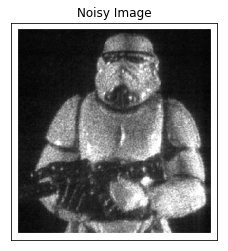

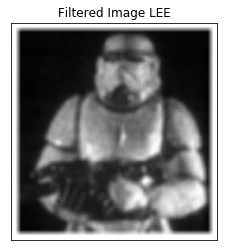

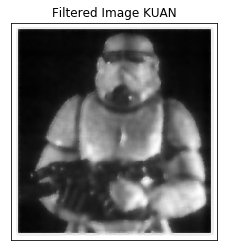

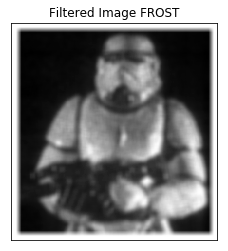

In [19]:
img=cv2.imread('storm.png',0)
height, width = img.shape[:2]
img = cv2.resize(img,(np.uint16(0.5*width), np.uint16(0.5*height)), interpolation = cv2.INTER_CUBIC)
x,y=img.shape

img_lee=lee_filter(img,size=11)
img_kuan=kuan_filter(img,win_size=11)
img_frost=frost_filter(img,win_size=11)
plt.imshow(img, cmap='gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_lee, cmap='gray')
plt.title('Filtered Image LEE'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_kuan, cmap='gray')
plt.title('Filtered Image KUAN'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_frost, cmap='gray')
plt.title('Filtered Image FROST'), plt.xticks([]), plt.yticks([])
plt.show()

In [20]:
print('SNR_in: ',SNR(img), ' SNR_LEE: ',SNR(img_lee), ' SNR_KUAN: ',SNR(img_kuan), ' SNR_FROST: ',SNR(img_frost))
print('ENL_in: ',ENL(img), ' ENL_LEE: ',ENL(img_lee), ' ENL_KUAN: ',ENL(img_kuan), ' ENL_FROST: ',ENL(img_frost))
print('SSI_in: ',SSI(img,img), ' SSI_LEE: ',SSI(img,img_lee), ' SSI_KUAN: ',SSI(img,img_kuan), ' SSI_FROST: ',SSI(img,img_frost))
print('SMPI_in: ',SMPI(img,img), ' SMPI_LEE: ',SMPI(img,img_lee), ' SMPI_KUAN: ',SMPI(img,img_kuan), ' SMPI_FROST: ',SMPI(img,img_frost))
print('Q_in: ',Q_factor(img,img), ' Q_LEE: ',Q_factor(img,img_lee), ' Q_KUAN: ',Q_factor(img,img_kuan), ' Q_FROST: ',Q_factor(img,img_frost))

SNR_in:  1.3817479845  SNR_LEE:  1.48614516655  SNR_KUAN:  1.43122476847  SNR_FROST:  1.4923966661
ENL_in:  1.90922749266  ENL_LEE:  2.20862745607  ENL_KUAN:  2.04840433789  ENL_FROST:  2.22724780897
SSI_in:  1.0  SSI_LEE:  0.929753038663  SSI_KUAN:  0.965430458538  SSI_FROST:  0.92585839669
SMPI_in:  1.0  SMPI_LEE:  1.6931149333  SMPI_KUAN:  1.80785244844  SMPI_FROST:  1.35992194874
Q_in:  81.3448738862  Q_LEE:  86.8411380263  Q_KUAN:  83.5923268332  Q_FROST:  87.4875307965


/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:119: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/caasalazarsa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


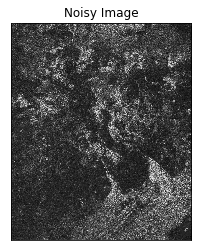

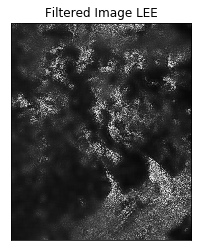

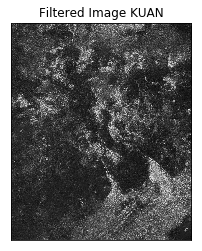

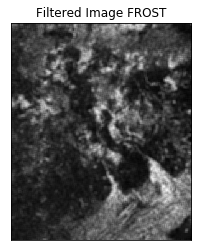

In [25]:
img=np.float32(cv2.imread('satellite.png',0))
height, width = img.shape[:2]
img = cv2.resize(img,(np.uint16(0.5*width), np.uint16(0.5*height)), interpolation = cv2.INTER_CUBIC)
x,y=img.shape

img_lee=lee_filter(img,size=11)
img_kuan=kuan_filter(img,win_size=11)
img_frost=frost_filter(img,win_size=5)
plt.imshow(img, cmap='gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_lee, cmap='gray')
plt.title('Filtered Image LEE'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_kuan, cmap='gray')
plt.title('Filtered Image KUAN'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(img_frost, cmap='gray')
plt.title('Filtered Image FROST'), plt.xticks([]), plt.yticks([])
plt.show()

In [26]:
print('SNR_in: ',SNR(img), ' SNR_LEE: ',SNR(img_lee), ' SNR_KUAN: ',SNR(img_kuan), ' SNR_FROST: ',SNR(img_frost))
print('ENL_in: ',ENL(img), ' ENL_LEE: ',ENL(img_lee), ' ENL_KUAN: ',ENL(img_kuan), ' ENL_FROST: ',ENL(img_frost))
print('SSI_in: ',SSI(img,img), ' SSI_LEE: ',SSI(img,img_lee), ' SSI_KUAN: ',SSI(img,img_kuan), ' SSI_FROST: ',SSI(img,img_frost))
print('SMPI_in: ',SMPI(img,img), ' SMPI_LEE: ',SMPI(img,img_lee), ' SMPI_KUAN: ',SMPI(img,img_kuan), ' SMPI_FROST: ',SMPI(img,img_frost))
print('Q_in: ',Q_factor(img,img), ' Q_LEE: ',Q_factor(img,img_lee), ' Q_KUAN: ',Q_factor(img,img_kuan), ' Q_FROST: ',Q_factor(img,img_frost))

SNR_in:  1.39935  SNR_LEE:  1.928  SNR_KUAN:  1.66718362689  SNR_FROST:  2.2211
ENL_in:  1.95819022966  ENL_LEE:  3.7171875744  ENL_KUAN:  2.77950124577  ENL_FROST:  4.93328561839
SSI_in:  1.0  SSI_LEE:  0.725805  SSI_KUAN:  0.839351755626  SSI_FROST:  0.630027
SMPI_in:  1.0  SMPI_LEE:  1.0240688569  SMPI_KUAN:  0.874133438165  SMPI_FROST:  0.639710566029
Q_in:  44.4224799016  Q_LEE:  60.0275138215  Q_KUAN:  52.8888665729  Q_FROST:  70.4911051113
